# Data Augmentation

The [PlantVillage-Dataset](https://github.com/spMohanty/PlantVillage-Dataset/blob/master/README.md), is a dataset of plant leaf images  categorized per species and per health conditions. The dataset containes 38 classes, but the number of elements per class can vary significantly between them.

Although the dataset includes 38 classes, the number of samples per class varies significantly, making the dataset imbalanced.

This notebook aims to balence the classes by applying a class-specific data augmentation, and then to proceed with the training of the model with the augmented dataset.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Install required libraries
%pip install tensorflow_datasets
#TOGLI %pip install collections

In [19]:
# Import all necessary libraries and functions
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pandas as pd
import random
#import sys
from tqdm.notebook import tqdm
#sys.path.append('./src')

In [6]:
# Load the PlantVillage dataset from the tensorflow_datasets library
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True    #returns metadata regarding the dataset
)

# Count number of samples in each subset
train_count = sum(1 for _ in ds_train)
val_count = sum(1 for _ in ds_val)
test_count = sum(1 for _ in ds_test)
dataset_count = train_count + val_count + test_count

print(f"The Plantvillage dataset contains: {dataset_count} samples")
print("Dataset Splitting: 80/10/10 Train-Validation-Test Ratio")
print(f"Training set: {train_count} samples")
print(f"Validation set: {val_count} samples")
print(f"Test set: {test_count} samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.VECG4L_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
The Plantvillage dataset contains: 54303 samples
Dataset Splitting: 80/10/10 Train-Validation-Test Ratio
Training set: 43442 samples
Validation set: 5431 samples
Test set: 5430 samples


## Training dataset data augmentation

Original training dataset informations:

Number of classes: 38


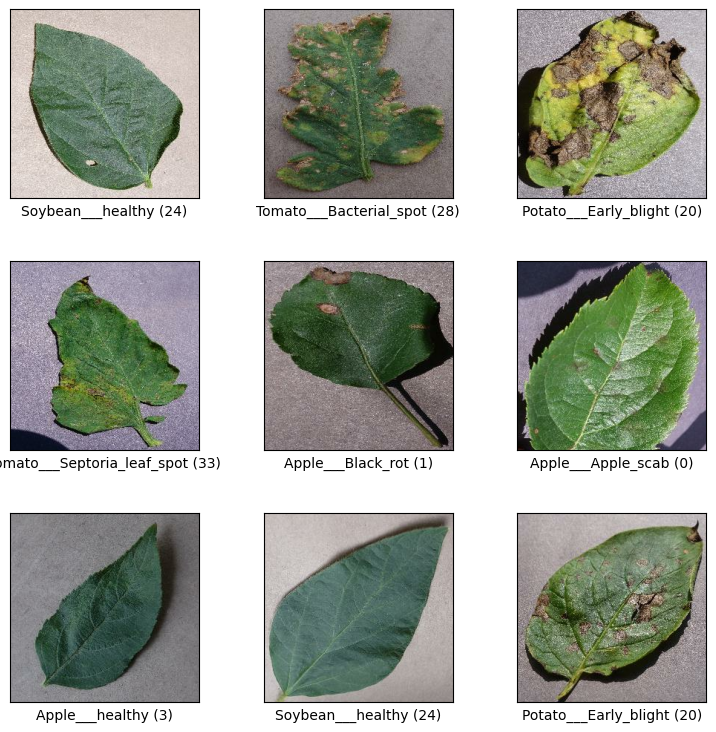

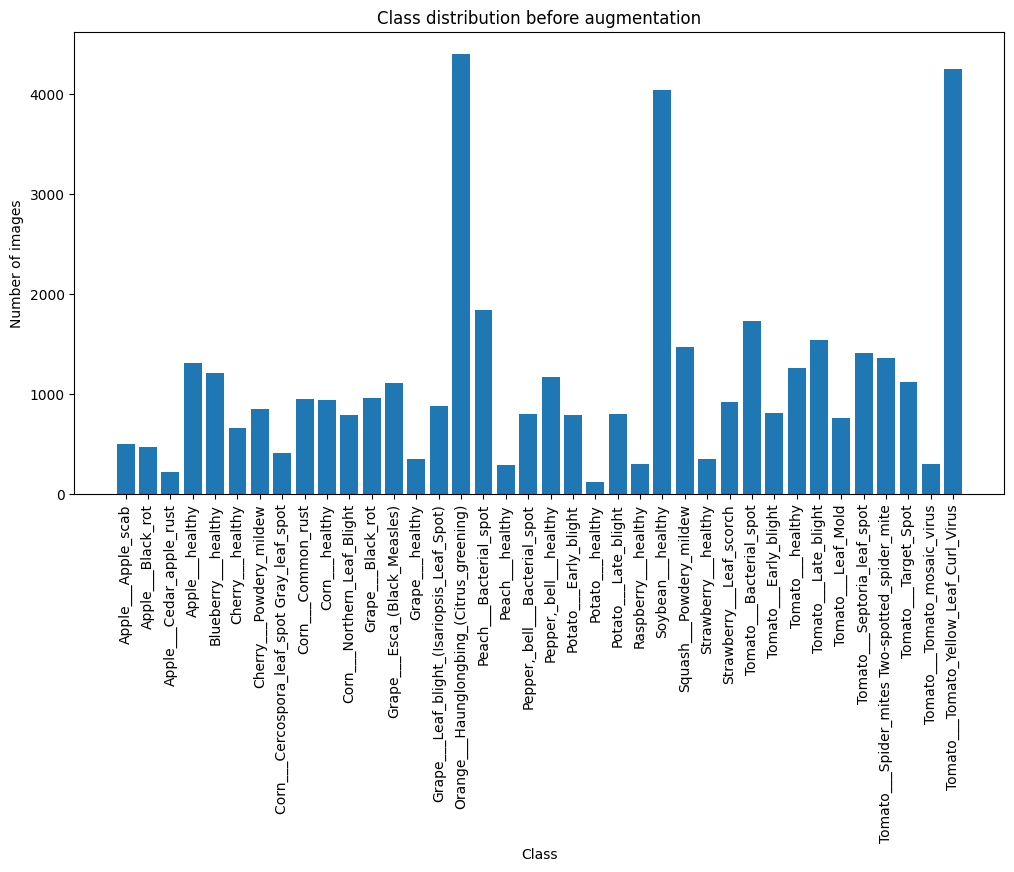

Number of images per class:
Apple___Apple_scab: 501 images
Apple___Black_rot: 467 images
Apple___Cedar_apple_rust: 221 images
Apple___healthy: 1306 images
Blueberry___healthy: 1210 images
Cherry___healthy: 659 images
Cherry___Powdery_mildew: 851 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 405 images
Corn___Common_rust: 953 images
Corn___healthy: 939 images
Corn___Northern_Leaf_Blight: 788 images
Grape___Black_rot: 956 images
Grape___Esca_(Black_Measles): 1111 images
Grape___healthy: 349 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881 images
Orange___Haunglongbing_(Citrus_greening): 4399 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 292 images
Pepper,_bell___Bacterial_spot: 800 images
Pepper,_bell___healthy: 1173 images
Potato___Early_blight: 792 images
Potato___healthy: 122 images
Potato___Late_blight: 801 images
Raspberry___healthy: 302 images
Soybean___healthy: 4043 images
Squash___Powdery_mildew: 1466 images
Strawberry___healthy: 353 images
Strawberry___L

In [34]:
# Extract only labels (not images) for counting
labels_list = []
for _, label in ds_train:      # Iterate over the dataset, ignoring the image (_) and extracting the label
    labels_list.append(label.numpy())

# Convert to pandas Series for fast operations
labels_series = pd.Series(labels_list)

number_of_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {number_of_classes}")
class_names = ds_info.features['label'].names

# Count using pandas (fast) but memory-efficient
class_counts = labels_series.value_counts().sort_index()

# Count original class samples (before augmentation)
original_counts = labels_series.value_counts().sort_index()

# Show example from the dataset
tfds.show_examples(ds_train, ds_info)

plt.figure(figsize=(12,6))
plt.bar(class_names, original_counts)
plt.title("Class distribution before augmentation")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()

# Print the counts with class names
print("Number of images per class:")
for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} images")


In [8]:
# Useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
N_EPOCHS = 30
NUM_CLASSES = ds_info.features['label'].num_classes
DROP_RATE = 0.3
L2_REGULARIZATION = 0.005

Target sample size and data augmentation pipelines:

In [41]:
#def preprocess(image, label):
#    image = tf.image.resize(image, IMG_SIZE)
#    image = tf.cast(image, tf.float32) / 255.0
#    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

def preprocess(image, label, dataset_info, image_size=(128, 128)):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, dataset_info.features['label'].num_classes)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess_with_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)  # <-- augment here
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

# Geometric augmentation
geo_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomRotation(0.1),
])

def preprocess_geo_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

# Color augmentation
color_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3),  # Brightness change
    tf.keras.layers.RandomContrast(0.2),    # Contrast variation
    tf.keras.layers.RandomSaturation(0.2),  # (optional) Color intensity variation
])

def preprocess_color_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.clip_by_value(aug_image, 0.0, 255.0)
    image = tf.cast(aug_image, tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

# Combining the two types of augmentation
combined_data_augmentation = tf.keras.Sequential([
    # Geometric augmentations
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),

    # Color augmentations
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Lambda(lambda x: tf.image.random_saturation(x, 0.8, 1.2)),

])

def preprocess_combined_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label, ds_info.features['label'].num_classes


## Augmentation

In [45]:
# Choose number of samples per class:
#'max': # of samples in largest class
#'mean': mean # of samples
#'t': 1000 samples
#'min': # of samples in the smallest class

target_type = input("Choose the number of samples per class('max', 'mean', 't', 'min'): ").strip().lower()
if target_type not in ['max', 'mean', 't', 'min']:
    raise ValueError("Invalid choice! Please enter 'max', 'mean', 't', or 'min'.")

print(f"You chose: {target_type}")

if target_type == 'max':
  target = class_counts.max()

elif target_type == 'mean':
  target = round(class_counts.mean())

elif target_type == 't':
  target = 1000

elif target_type == 'min':
  target = class_counts.min()

samplesize = str(target)

# Choose augmentation type:
#'comb': geometric and color augmentation
#'geo': geometric augmentation
#'color': color augmentation

augmentation_type = input("Choose augmentation type ('comb', 'geo', 'color'): ").strip().lower()
if augmentation_type not in ['comb', 'geo', 'color']:
    raise ValueError("Invalid choice! Please enter 'none', 'geo', or 'color'.")

print(f"You chose: {augmentation_type}")

if augmentation_type == 'comb':
  def augment(image):
    image = combined_data_augmentation(image)
    return image
  def preprocess_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

elif augmentation_type == 'geo':
  def augment(image, label):
    image = geo_augmentation(image)
    return image, label

  def preprocess_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

elif augmentation_type == 'color':
  def augment(image, label):
    image = geo_augmentation(image)
    return image, label

  def preprocess_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Setting output directory to Google Drive folder and creating the new classes
output_root = '/content/drive/MyDrive/MACHINE_LEARNING/progetto-daml/'+augmentation_type+'_aug_'+samplesize
#output_root = 'augmented_data'
print(output_root)

Choose the number of samples per class('max', 'mean', 't', 'min'): mean
You chose: mean
Choose augmentation type ('comb', 'geo', 'color'): geo
You chose: geo
/content/drive/MyDrive/MACHINE_LEARNING/progetto-daml/geo_aug_1143


In [44]:

os.makedirs(output_root, exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join(output_root, class_name), exist_ok=True)

# Convert class_counts to dict for faster lookup
class_counts_dict = dict(class_counts)
target_per_class = {i: target for i in range(len(class_names))}

# Initialize counters more efficiently
new_class_elements = {i: 0 for i in range(len(class_names))}   # Dictionary for the new classes and their # of samples
class_elements = class_counts_dict.copy()  # Start with original counts

# Calculating which classes need augmentation
# If the target is smaller than the number of samples in some classes,
# those classes won't need any augmentation and will be subject to downsampling

if class_counts.max() >= target:
  if class_counts.min() >= target:
    classes_to_modify = {i for i in range(len(class_names))}
    print("All classes will undergo downsampling")
  else:
    classes_needing_aug = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target}
    classes_to_modify = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target or class_counts_dict.get(i,0) > target}
    new_class_aug_elements = {i: (target - class_counts.values[i]) for i in range(len(class_names)) if target - class_counts.values[i] > 0} # Calculating the number of augmented images needed for the underrappresented classes to reach the target
    aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}   # Making the values int variables

# If the target is grater than the greatest number of samples recorded,
# all classes will be subject to data augmentation
if class_counts.max() < target:
  classes_needing_aug = {i for i in range(len(class_names))}
  new_class_aug_elements = {i: target - class_counts.values[i]for i in range(len(class_names))}
  aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}
  print("All classes will undergo data augmentation")

print("Classes needing augmentation:")
for idx in classes_needing_aug:
    print(f"{class_names[idx]}")

print(f"Target images per class: {target}")
print(f"Classes undergoing data augmentation: {len(classes_needing_aug)}")
print(f"Classes undergoing downsampling: {len(classes_to_modify) - len(classes_needing_aug)}")

# Add progress tracking
from tqdm.notebook import tqdm

# Augmentation loop
total_needed = sum(max(0, target - class_counts_dict.get(i, 0)) for i in range(len(class_names)))
pbar = tqdm(total=total_needed, desc="Augmenting images")
print(f"Total needed: {total_needed}")



# Saving images loop
total_saved = target*len(class_names)
pbar1 = tqdm(total = total_saved, desc="Saving images")
print(f"Total saved: {total_saved}")


# Use enumerate with early stopping
for i, (image, label) in enumerate(ds_train.repeat()):
    label_index = label.numpy()
    label_name = class_names[label_index]
    print(f"class #{i+1}: {class_names[label_index]}")

    # Early termination check - if no more classes need more samples
    if all(count >= target for count in new_class_elements.values()):
      print(f" All classes have {target} images.")
      print("Current class counts:", new_class_elements)
      break

    # Checking if this specific class still needs samples
    if new_class_elements[label_index] >= target:
      if label_index in classes_needing_aug:
        classes_needing_aug.discard(label_index)
        continue
      continue

    # Always save the original image first
    save_path = os.path.join(output_root, label_name, f'img_{new_class_elements[label_index]}.png')
    tf.keras.preprocessing.image.save_img(save_path, image.numpy())

    # Update counters following the addition of one image
    new_class_elements[label_index] += 1
    pbar1.update(1)

    print(f"Original Image saved in class: {class_names[label_index]}")
    #print(f"Nella lista delle classi in need: {classes_needing_aug[label_index]}")

    # Checking if a specific class still needs augmented samples
    if label_index in classes_needing_aug:
      if aug_elements_dict[label_index] == 0:
        continue

    # Early termination check - if this class is done, skip augmentation
    if new_class_elements[label_index] >= target:
      print(f"Class does not need anymore samples: {class_names[label_index]}")
      # Remove from classes needing augmentation
      classes_needing_aug.discard(label_index)
      # Check if all classes are balanced
      if not classes_needing_aug:
        print("\nAll classes balanced!")
        break
      continue

    # Only augment if this class still needs more samples
    if label_index in classes_needing_aug and new_class_elements[label_index] < target:
      # Apply augmentation with TensorFlow operations (faster than sequential)
      # Convert to float32 for augmentation operations
      aug_image = augment(image)

      # Convert back to uint8
      #aug_image = tf.clip_by_value(aug_image, 0.0, 255.0)
      aug_image = tf.cast(aug_image, tf.uint8)

      # Save augmented image
      save_path_aug = os.path.join(output_root, label_name, f'aug_{new_class_elements[label_index]}.png')
      tf.keras.preprocessing.image.save_img(save_path_aug, aug_image.numpy())
      print(f"Aug image saved in class: {class_names[label_index]}")

      # Update counters following the augmatation of one image
      class_elements[label_index] += 1
      new_class_aug_elements[label_index] -= 1
      new_class_elements[label_index] += 1
      aug_elements_dict[label_index] -= 1
      pbar.update(1)
      pbar1.update(1)


pbar.close()
pbar1.close()

# Print final statistics
print("\nFinal class distribution:")
for idx, count in new_class_elements.items():
    print(f"{class_names[idx]}: {count} images")

total_obtained = sum(new_class_elements.values())
print(f"Total obtained: {total_obtained}")


Classes needing augmentation:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Cherry___healthy
Cherry___Powdery_mildew
Corn___Cercospora_leaf_spot Gray_leaf_spot
Corn___Common_rust
Corn___healthy
Corn___Northern_Leaf_Blight
Grape___Black_rot
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Peach___healthy
Pepper,_bell___Bacterial_spot
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Raspberry___healthy
Strawberry___healthy
Strawberry___Leaf_scorch
Tomato___Early_blight
Tomato___Leaf_Mold
Tomato___Tomato_mosaic_virus
Target images per class: 1000
Classes undergoing data augmentation: 23
Classes undergoing downsampling: 15


Augmenting images:   0%|          | 0/8777 [00:00<?, ?it/s]

Total needed: 8777


Saving images:   0%|          | 0/38000 [00:00<?, ?it/s]

Total saved: 38000
class #1: Soybean___healthy
Original Image saved in class: Soybean___healthy
class #2: Tomato___Bacterial_spot
Original Image saved in class: Tomato___Bacterial_spot
class #3: Apple___healthy
Original Image saved in class: Apple___healthy
class #4: Strawberry___Leaf_scorch
Original Image saved in class: Strawberry___Leaf_scorch
Aug image saved in class: Strawberry___Leaf_scorch
class #5: Strawberry___Leaf_scorch
Original Image saved in class: Strawberry___Leaf_scorch
Aug image saved in class: Strawberry___Leaf_scorch
class #6: Corn___Northern_Leaf_Blight
Original Image saved in class: Corn___Northern_Leaf_Blight
Aug image saved in class: Corn___Northern_Leaf_Blight
class #7: Pepper,_bell___Bacterial_spot
Original Image saved in class: Pepper,_bell___Bacterial_spot
Aug image saved in class: Pepper,_bell___Bacterial_spot
class #8: Tomato___Early_blight
Original Image saved in class: Tomato___Early_blight
Aug image saved in class: Tomato___Early_blight
class #9: Tomato_

KeyboardInterrupt: 

Total needed: 8777
Total needed: 1686
{0: np.int64(0), 1: np.int64(33), 2: np.int64(279), 5: np.int64(0), 6: np.int64(0), 7: np.int64(95), 8: np.int64(0), 9: np.int64(0), 10: np.int64(0), 11: np.int64(0), 13: np.int64(151), 14: np.int64(0), 17: np.int64(208), 18: np.int64(0), 20: np.int64(0), 21: np.int64(378), 22: np.int64(0), 23: np.int64(198), 26: np.int64(147), 27: np.int64(0), 29: np.int64(0), 32: np.int64(0), 36: np.int64(197)}
1686


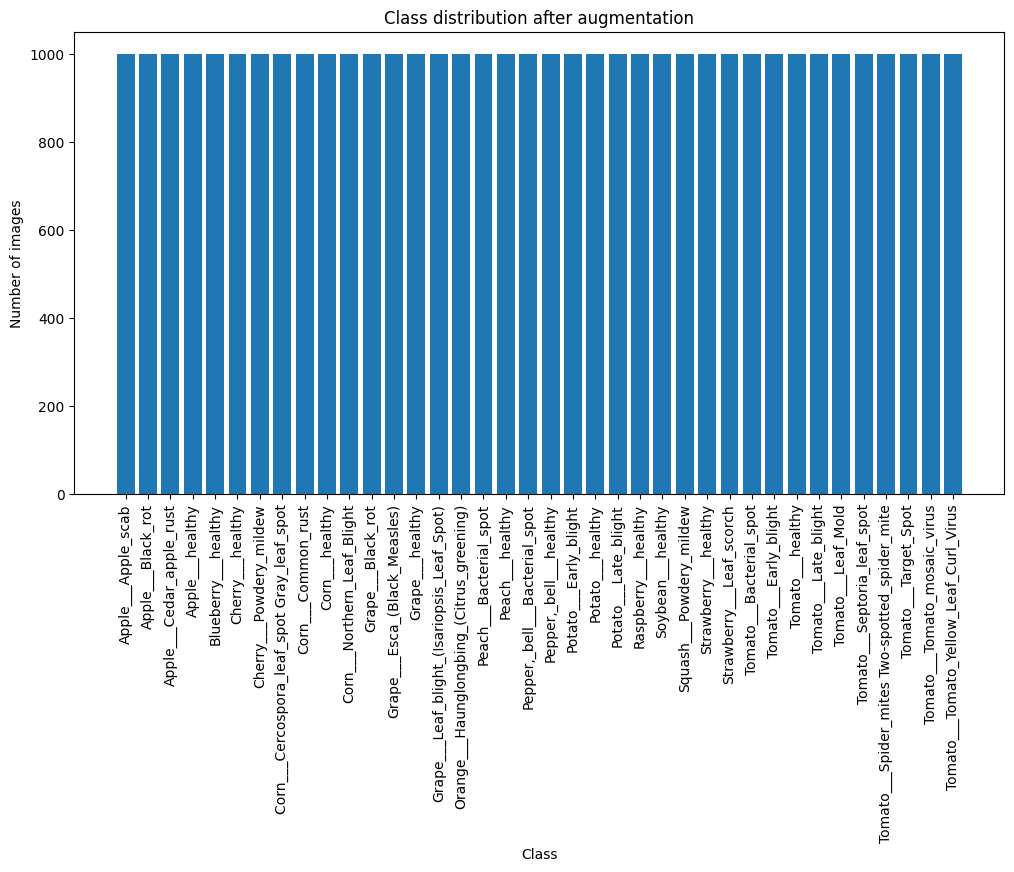

In [22]:
# Augmentation loop
total_needed = sum(target - class_counts_dict.get(i, 0) for i in range(len(class_names)) if target - class_counts_dict.get(i, 0) > 0)
#pbar = tqdm(total = total_needed, desc="Augmenting images")
print(f"Total needed: {total_needed}")

total_needed = sum(target - class_elements.get(i, 0) for i in range(len(class_names)) if target - class_counts_dict.get(i, 0) > 0)
#pbar = tqdm(total = total_needed, desc="Augmenting images")
print(f"Total needed: {total_needed}")
#total_needed = sum(target - class_elements.get(i, 0) for i in range(len(class_names)) if target - class_counts_dict.get(i, 0) > 0)
#pbar = tqdm(total = total_needed, desc="Augmenting images")
print(new_class_aug_elements)
print( sum(aug_elements_dict.values()))

# Count original class samples (before augmentation)
original_counts = labels_series.value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(class_names, new_class_elements.values())
plt.title("Class distribution after augmentation")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()

In [27]:
# Print final statistics
total_obtained = sum(new_class_elements.values())
print(f"Total obtained: {total_obtained}")
print("\nFinal class distribution:")
for idx, count in new_class_elements.items():
    print(f"{class_names[idx]}: {count} images")

print("\nOriginal class distribution:")
for idx, count in class_counts_dict.items():
    print(f"{class_names[idx]}: {count} images")

Total obtained: 38000

Final class distribution:
Apple___Apple_scab: 1000 images
Apple___Black_rot: 1000 images
Apple___Cedar_apple_rust: 1000 images
Apple___healthy: 1000 images
Blueberry___healthy: 1000 images
Cherry___healthy: 1000 images
Cherry___Powdery_mildew: 1000 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 1000 images
Corn___Common_rust: 1000 images
Corn___healthy: 1000 images
Corn___Northern_Leaf_Blight: 1000 images
Grape___Black_rot: 1000 images
Grape___Esca_(Black_Measles): 1000 images
Grape___healthy: 1000 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1000 images
Orange___Haunglongbing_(Citrus_greening): 1000 images
Peach___Bacterial_spot: 1000 images
Peach___healthy: 1000 images
Pepper,_bell___Bacterial_spot: 1000 images
Pepper,_bell___healthy: 1000 images
Potato___Early_blight: 1000 images
Potato___healthy: 1000 images
Potato___Late_blight: 1000 images
Raspberry___healthy: 1000 images
Soybean___healthy: 1000 images
Squash___Powdery_mildew: 1000 images
Strawber

In [ ]:
os.makedirs(output_root, exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join(output_root, class_name), exist_ok=True)

# Convert class_counts to dict for faster lookup
class_counts_dict = dict(class_counts)
target_per_class = {i: target for i in range(len(class_names))}

# Initialize counters more efficiently
new_class_elements = {i: 0 for i in range(len(class_names))}   # Dictionary for the new classes and their # of samples
class_elements = class_counts_dict.copy()  # Start with original counts

# Calculating which classes need augmentation
# If the target is smaller than the number of samples in some classes,
# those classes won't need any augmentation and will be subject to downsampling

if class_counts.max() >= target:
  if class_counts.min() >= target:
    classes_to_modify = {i for i in range(len(class_names))}
    print("All classes will undergo downsampling")
  else:
    classes_needing_aug = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target}
    classes_to_modify = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target or class_counts_dict.get(i,0) > target}
    new_class_aug_elements = {i: (target - class_counts.values[i]) for i in range(len(class_names)) if target - class_counts.values[i] > 0} # Calculating the number of augmented images needed for the underrappresented classes to reach the target
    aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}   # Making the values int variables

# If the target is grater than the greatest number of samples recorded,
# all classes will be subject to data augmentation
if class_counts.max() < target:
  classes_needing_aug = {i for i in range(len(class_names))}
  new_class_aug_elements = {i: target - class_counts.values[i]for i in range(len(class_names))}
  aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}
  print("All classes will undergo a color wise data augmentation")

print("Classes needing augmentation:")
for idx in classes_needing_aug:
    print(f"{class_names[idx]}")

print(f"Target images per class: {target}")
print(f"Classes undergoing a color wise data augmentation: {len(classes_needing_aug)}")
print(f"Classes undergoing downsampling: {len(classes_to_modify) - len(classes_needing_aug)}")

# Add progress tracking
from tqdm.notebook import tqdm

# Augmentation loop
total_needed = sum(max(0, target - class_counts_dict.get(i, 0)) for i in range(len(class_names)))
pbar = tqdm(total=total_needed, desc="Augmenting images")
print(f"Total needed: {total_needed}")

# Saving images loop
total_saved = target*len(class_names)
pbar1 = tqdm(total = total_saved, desc="Saving images")
print(f"Total saved: {total_saved}")


# Use enumerate with early stopping
for i, (image, label) in enumerate(ds_train.repeat()):
    label_index = label.numpy()
    label_name = class_names[label_index]
    print(f"class #{i+1}: {class_names[label_index]}")

    # Early termination check - if no more class needs more samples
    if all(count >= target for count in new_class_elements.values()):
      print(f" All classes have {target} images.")
      print("Current class counts:", new_class_elements)
      break

    # Checking if a specific class still needs samples
    if new_class_elements[label_index] >= target:
      if label_index in classes_needing_aug:
        classes_needing_aug.discard(label_index)
        continue
      continue

    # Always save the original image first
    save_path = os.path.join(output_root, label_name, f'img_{new_class_elements[label_index]}.png')
    tf.keras.preprocessing.image.save_img(save_path, image.numpy())

    # Update counters following the addition of one image
    new_class_elements[label_index] += 1
    pbar1.update(1)

    print(f"Original image saved in class: {class_names[label_index]}")
    #print(f"Nella lista delle classi in need: {classes_needing_aug[label_index]}")

    # Checking if a specific class still needs augmented samples
    if label_index in classes_needing_aug:
      if aug_elements_dict[label_index] == 0:
        continue

    # Early termination check - if this class is done, skip augmentation
    if new_class_elements[label_index] >= target:
      print(f"Class does not need anymore samples: {class_names[label_index]}")
      # Remove from classes needing augmentation
      classes_needing_aug.discard(label_index)
      # Check if all classes are balanced
      if not classes_needing_aug:
        print("\nAll classes balanced!")
        break
      continue

    # Only augment if this class still needs more samples
    if label_index in classes_needing_aug and new_class_elements[label_index] < target:
      # Apply augmentation with TensorFlow operations (faster than sequential)
      # Convert to float32 for augmentation operations
      aug_image = color_augmentation(image)

      #  Clip values to valid range and convert back to uint8
      aug_image = tf.clip_by_value(aug_image, 0.0, 255.0)
      aug_image = tf.cast(aug_image, tf.uint8)

      # Save augmented image
      save_path_aug = os.path.join(output_root, label_name, f'aug_{new_class_elements[label_index]}.png')
      tf.keras.preprocessing.image.save_img(save_path_aug, aug_image.numpy())
      print(f"Color augmented image saved in class: {class_names[label_index]}")

      # Update counters following the augmatation of one image
      class_elements[label_index] += 1
      new_class_aug_elements[label_index] -= 1
      new_class_elements[label_index] += 1
      aug_elements_dict[label_index] -= 1
      pbar.update(1)
      pbar1.update(1)


pbar.close()
pbar1.close()

# Print final statistics
print("\nFinal class distribution:")
for idx, count in new_class_elements.items():
    print(f"{class_names[idx]}: {count} images")

total_obtained = sum(new_class_elements.values())
print(f"Total obtained: {total_obtained}")


Classes needing augmentation:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Cherry___healthy
Cherry___Powdery_mildew
Corn___Cercospora_leaf_spot Gray_leaf_spot
Corn___Common_rust
Corn___healthy
Corn___Northern_Leaf_Blight
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Peach___healthy
Pepper,_bell___Bacterial_spot
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Raspberry___healthy
Strawberry___healthy
Strawberry___Leaf_scorch
Tomato___Early_blight
Tomato___Leaf_Mold
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Target images per class: 1143
Classes undergoing data augmentation: 25
Classes undergoing downsampling: 13


Augmenting images:   0%|          | 0/12117 [00:00<?, ?it/s]

Total needed: 12117


Saving images:   0%|          | 0/43434 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
class #198069: Pepper,_bell___healthy
class #198070: Apple___Black_rot
class #198071: Tomato___Leaf_Mold
class #198072: Tomato___Bacterial_spot
class #198073: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198074: Soybean___healthy
class #198075: Peach___healthy
class #198076: Tomato___healthy
class #198077: Apple___healthy
class #198078: Soybean___healthy
class #198079: Pepper,_bell___Bacterial_spot
class #198080: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198081: Pepper,_bell___Bacterial_spot
class #198082: Soybean___healthy
class #198083: Tomato___Target_Spot
class #198084: Pepper,_bell___healthy
class #198085: Strawberry___healthy
class #198086: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198087: Tomato___Late_blight
class #198088: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198089: Tomato___Septoria_leaf_spot
class #198090: Squash___Powdery_mildew
class #198091: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198092: Pepper,_b

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [ ]:
# Setting output directory to Google Drive folder and creating the new classes
output_root = '/content/drive/MyDrive/MACHINE_LEARNING/progetto-daml/Comb_augmentatio_mean'
#output_root = 'augmented_data'
os.makedirs(output_root, exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join(output_root, class_name), exist_ok=True)

# Convert class_counts to dict for faster lookup
class_counts_dict = dict(class_counts)
target_per_class = {i: target for i in range(len(class_names))}

# Initialize counters more efficiently
new_class_elements = {i: 0 for i in range(len(class_names))}   # Dictionary for the new classes and their # of samples
class_elements = class_counts_dict.copy()  # Start with original counts

# Calculating which classes need augmentation
# If the target is smaller than the number of samples in some classes,
# those classes won't need any augmentation and will be subject to downsampling

if class_counts.max() >= target:
  if class_counts.min() >= target:
    classes_to_modify = {i for i in range(len(class_names))}
    print("All classes will undergo downsampling")
  else:
    classes_needing_aug = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target}
    classes_to_modify = {i for i in range(len(class_names)) if class_counts_dict.get(i, 0) < target or class_counts_dict.get(i,0) > target}
    new_class_aug_elements = {i: (target - class_counts.values[i]) for i in range(len(class_names)) if target - class_counts.values[i] > 0} # Calculating the number of augmented images needed for the underrappresented classes to reach the target
    aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}   # Making the values int variables

# If the target is grater than the greatest number of samples recorded,
# all classes will be subject to data augmentation
if class_counts.max() < target:
  classes_needing_aug = {i for i in range(len(class_names))}
  new_class_aug_elements = {i: target - class_counts.values[i]for i in range(len(class_names))}
  aug_elements_dict = {k: int(v) for k, v in new_class_aug_elements.items()}
  print("All classes will undergo data augmentation")

print("Classes needing augmentation:")
for idx in classes_needing_aug:
    print(f"{class_names[idx]}")

print(f"Target images per class: {target}")
print(f"Classes undergoing data augmentation: {len(classes_needing_aug)}")
print(f"Classes undergoing downsampling: {len(classes_to_modify) - len(classes_needing_aug)}")

# Add progress tracking
from tqdm.notebook import tqdm

# Augmentation loop
total_needed = sum(max(0, target - class_counts_dict.get(i, 0)) for i in range(len(class_names)))
pbar = tqdm(total=total_needed, desc="Augmenting images")
print(f"Total needed: {total_needed}")

# Saving images loop
total_saved = target*len(class_names)
pbar1 = tqdm(total = total_saved, desc="Saving images")
print(f"Total saved: {total_saved}")


# Use enumerate with early stopping
for i, (image, label) in enumerate(ds_train.repeat()):
    label_index = label.numpy()
    label_name = class_names[label_index]
    print(f"class #{i+1}: {class_names[label_index]}")

    # Early termination check - if no more class needs more samples
    if all(count >= target for count in new_class_elements.values()):
      print(f" All classes have {target} images.")
      print("Current class counts:", new_class_elements)
      break

    # Checking if a specific class still needs samples
    if new_class_elements[label_index] >= target:
      if label_index in classes_needing_aug:
        classes_needing_aug.discard(label_index)
        continue
      continue

    # Always save the original image first
    save_path = os.path.join(output_root, label_name, f'img_{new_class_elements[label_index]}.png')
    tf.keras.preprocessing.image.save_img(save_path, image.numpy())

    # Update counters following the addition of one image
    new_class_elements[label_index] += 1
    pbar1.update(1)

    print(f"Original image saved in class: {class_names[label_index]}")
    #print(f"Nella lista delle classi in need: {classes_needing_aug[label_index]}")

    # Checking if a specific class still needs augmented samples
    if label_index in classes_needing_aug:
      if aug_elements_dict[label_index] == 0:
        continue

    # Early termination check - if this class is done, skip augmentation
    if new_class_elements[label_index] >= target:
      print(f"Class does not need anymore samples: {class_names[label_index]}")
      # Remove from classes needing augmentation
      classes_needing_aug.discard(label_index)
      # Check if all classes are balanced
      if not classes_needing_aug:
        print("\nAll classes balanced!")
        break
      continue

    # Only augment if this class still needs more samples
    if label_index in classes_needing_aug and new_class_elements[label_index] < target:
      # Apply augmentation with TensorFlow operations (faster than sequential)
      # Convert to float32 for augmentation operations
      aug_image = combined_data_augmentation(image)

      #  Clip values to valid range and convert back to uint8
      aug_image = tf.clip_by_value(aug_image, 0.0, 255.0)
      aug_image = tf.cast(aug_image, tf.uint8)

      # Save augmented image
      save_path_aug = os.path.join(output_root, label_name, f'aug_{new_class_elements[label_index]}.png')
      tf.keras.preprocessing.image.save_img(save_path_aug, aug_image.numpy())
      print(f"Augmented image saved in class: {class_names[label_index]}")

      # Update counters following the augmatation of one image
      class_elements[label_index] += 1
      new_class_aug_elements[label_index] -= 1
      new_class_elements[label_index] += 1
      aug_elements_dict[label_index] -= 1
      pbar.update(1)
      pbar1.update(1)


pbar.close()
pbar1.close()

# Print final statistics
print("\nFinal class distribution:")
for idx, count in new_class_elements.items():
    print(f"{class_names[idx]}: {count} images")

total_obtained = sum(new_class_elements.values())
print(f"Total obtained: {total_obtained}")


Classes needing augmentation:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Cherry___healthy
Cherry___Powdery_mildew
Corn___Cercospora_leaf_spot Gray_leaf_spot
Corn___Common_rust
Corn___healthy
Corn___Northern_Leaf_Blight
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Peach___healthy
Pepper,_bell___Bacterial_spot
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Raspberry___healthy
Strawberry___healthy
Strawberry___Leaf_scorch
Tomato___Early_blight
Tomato___Leaf_Mold
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Target images per class: 1143
Classes undergoing data augmentation: 25
Classes undergoing downsampling: 13


Augmenting images:   0%|          | 0/12117 [00:00<?, ?it/s]

Total needed: 12117


Saving images:   0%|          | 0/43434 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
class #198069: Pepper,_bell___healthy
class #198070: Apple___Black_rot
class #198071: Tomato___Leaf_Mold
class #198072: Tomato___Bacterial_spot
class #198073: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198074: Soybean___healthy
class #198075: Peach___healthy
class #198076: Tomato___healthy
class #198077: Apple___healthy
class #198078: Soybean___healthy
class #198079: Pepper,_bell___Bacterial_spot
class #198080: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198081: Pepper,_bell___Bacterial_spot
class #198082: Soybean___healthy
class #198083: Tomato___Target_Spot
class #198084: Pepper,_bell___healthy
class #198085: Strawberry___healthy
class #198086: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198087: Tomato___Late_blight
class #198088: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198089: Tomato___Septoria_leaf_spot
class #198090: Squash___Powdery_mildew
class #198091: Tomato___Tomato_Yellow_Leaf_Curl_Virus
class #198092: Pepper,_b

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

# MODEL TRAINING

In [20]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [28]:
# Loading the new training set in the training notebook

from tensorflow.keras.utils import image_dataset_from_directory

# Define the path to the augmented data
augmented_data_path = output_root

# Load the dataset from the new directory
ds_augmented_train = tf.keras.utils.image_dataset_from_directory(
    augmented_data_path,
    labels='inferred',
    label_mode='categorical',   # one-hot encoding
    batch_size=32,
    image_size=(224, 224),      # before preprocessing
    shuffle=True,
    seed=123
)

# Get class names (sorted as image_dataset_from_directory does)
class_names = sorted(os.listdir(augmented_data_path))
print("Class names:", class_names)

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(augmented_data_path, cls))) for cls in class_names}

print("Number of images per class:")
for cls in class_names:
    print(f"{cls}: {class_counts[cls]} images")


Found 38000 files belonging to 38 classes.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomat

In [42]:
# Preprocessing
train_ds = ds_augmented_train.map(lambda image, label: preprocess_aug(image, label), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_val.map  (lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#test_ds  = ds_test.map (lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [46]:
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=38):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Dropout(0.4),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [47]:
model = simple_cnn()
model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with the input shape
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │     1,245,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,310 (4.77 MB)

 Trainable params: 1,250,310 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

n_epochs = 30

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=n_epochs,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('./weights/base_model.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4418 - loss: 2.0637

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 803s 671ms/step - accuracy: 0.4419 - loss: 2.0632 - val_accuracy: 0.4524 - val_loss: 2.8766 - learning_rate: 2.0000e-04
Epoch 2/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 786s 661ms/step - accuracy: 0.7590 - loss: 0.8262 - val_accuracy: 0.4872 - val_loss: 3.1748 - learning_rate: 2.0000e-04
Epoch 3/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 770s 648ms/step - accuracy: 0.8353 - loss: 0.5648 - val_accuracy: 0.4820 - val_loss: 3.5577 - learning_rate: 2.0000e-04
Epoch 4/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 776s 653ms/step - accuracy: 0.9017 - loss: 0.3598 - val_accuracy: 0.4925 - val_loss: 3.8487 - learning_rate: 4.0000e-05


In [52]:
model.save('/content/drive/MyDrive/MACHINE_LEARNING/progetto-daml/my_model.keras')